**6장 – 결정 트리**

_이 노트북은 6장에 있는 모든 샘플 코드와 연습문제 해답을 가지고 있습니다._

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/rickiepark/handson-ml2/blob/master/06_decision_trees.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩에서 실행하기</a>
  </td>
</table>

# 설정

먼저 몇 개의 모듈을 임포트합니다. 맷플롯립 그래프를 인라인으로 출력하도록 만들고 그림을 저장하는 함수를 준비합니다. 또한 파이썬 버전이 3.5 이상인지 확인합니다(파이썬 2.x에서도 동작하지만 곧 지원이 중단되므로 파이썬 3을 사용하는 것이 좋습니다). 사이킷런 버전이 0.20 이상인지도 확인합니다.

In [38]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "decision_trees"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 훈련과 시각화

In [39]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris()
X = iris.data[:, 2:] # 꽃잎 길이와 너비
y = iris.target

tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)

tree_clf.fit(X, y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=2, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

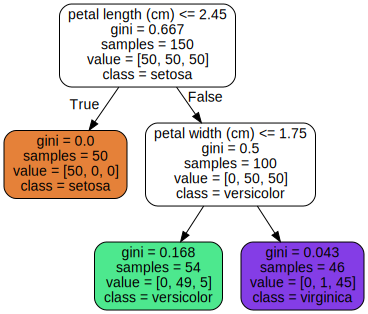

In [40]:
from graphviz import Source
from sklearn.tree import export_graphviz

export_graphviz(
        tree_clf,
        out_file=os.path.join(IMAGES_PATH, "iris_tree.dot"),
        feature_names=iris.feature_names[2:],   #조건을 표시할때 특성1이렇게 보는게 아니라 그 특성의 이름으로 표시
        class_names=iris.target_names,          #클래스 이름을 원래 클래스 이름으로 표시
        rounded=True,      #모서리 둥글게
        filled=True     #색을 칠하는거 (클래스별로)
    )

Source.from_file(os.path.join(IMAGES_PATH, "iris_tree.dot"))

루트 노드(root node) : 깊이가 0인 맨 꼭대기의 노드

리프 노드(leaf node) : 자식 노드를 가지지 않는 노드

gini : 지니 불순도

sample : 노드로 넘어온 샘플의 갯수

value : 노드로 넘어온 것을 각 클래스별로 몇개인지 알려준다

결정트리는 직관적이고 결정 방식을 이해하기 쉽다 -> 화이트 박스 모델

결정트리는 논 파라매트릭 모델(non parametric)
-> 학습해서 튜닝할 파라미터가 명시적으로 존재하지 않거나, 정확히 셀 수 없는 경우

(선형회귀는 매개변수 갯수가 정해있음 파라매트릭 모델)

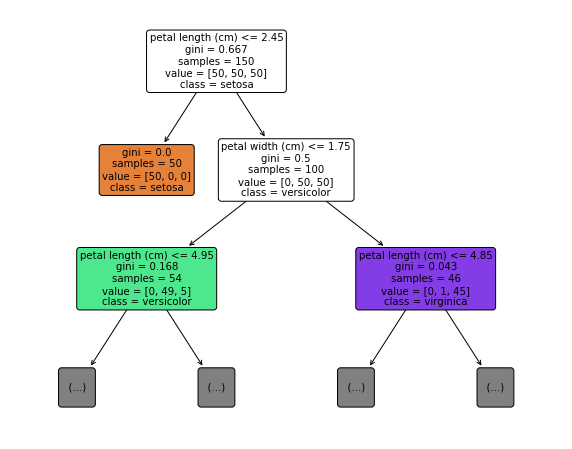

In [41]:
from sklearn.tree import plot_tree

tree_clf = DecisionTreeClassifier(random_state=42)      #리프노드의 지니 불순도가 0이 될때까지
tree_clf.fit(X, y)

plt.figure(figsize=(10, 8))
plot_tree(tree_clf, filled=True, rounded=True, max_depth=2,     #이 함수로 그림을 그릴때 위에서 훈련한 max_depth보다 적게 인수를 전달하면 그만큼만 그려진다
          feature_names=iris.feature_names[2:],
          class_names=iris.target_names)
plt.show()

왼쪽 리프노드(초록색)의 지니 불순도 구하기

1 - ( (0/54)^2 + (49/54)^2 + (5/54)^2 )

``엔트로피 불순도 구하기

\- ( (0/54)*log2(0/54) + (49/54)*log2(49/54) +(5/54)*log2(5/54) )

오른쪽 리프노드(보라색)의 지니 불순도 구하기

1 - ( (0/46)^2 + (1/46)^2 + (45/46)^2 )

`` 엔트로피 불순도 구하기

\- ( (0/46)*log2(0/46) + (1/46)*log2(1/46) +(45/46)*log2(45/46) )

**식 6-1: 지니 불순도**

$
G_i = 1 - \sum\limits_{k=1}^{n}{{p_{i,k}}^2}
$

$p_{i,k}$은 i번째 노드에 있는 훈련 샘플중 클래스 k에 속한 샘플의 비율
(비율의 분모는 그 노드의 sample수 분자는 value리스트안의 원소들)

**식 6-3: 엔트로피 불순도**

$
H_i = -\sum\limits_{k=1 \atop p_{i,k} \ne 0}^{n}{{p_{i,k}}\log_2(p_{i,k})}
$



불순도를 구할때 샘플의 비율을 계산했다

즉, 샘플의 특성값을 계산 하지 않았다 -> 거리 개념이 들어가지 않았다 -> 전처리가 필요없다

In [42]:
DecisionTreeClassifier(criterion='gini')        #지니 불순도가 기본

DecisionTreeClassifier(criterion='entropy')

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')


**식 6-2: 분류에 대한 CART 비용 함수**

$
\begin{split}
&J(k, t_k) = \dfrac{m_{\text{left}}}{m}G_\text{left} + \dfrac{m_{\text{right}}}{m}G_{\text{right}}\\
&\text{여기에서 }\begin{cases}
G_\text{left/right} \text{는 왼쪽/오른쪽 서브셋의 불순도}\\
m_\text{left/right} \text{는 왼쪽/오른쪽 서브셋의 샘플 수}
\end{cases}
\end{split}
$

m : 현재 노드의 샘플 수

사이킷런은 결정 트리를 훈련시키기 위해 CART(classification and regression tree)알고리즘을 사용한다. (질문에 대한 답이 예 아니오로 구분되게한다 -> 리프노드 외의 모든 노드는 자식 노드를 두 개씩 가진다)

최대 깊이가 되면 중지하거나 불순도를 줄이는 분할을 찾을 수 없을 때 중지

CART 알고리즘은 탐욕적 알고리즘. 즉 현재 단계의 분할이 몇 단계를 거쳐 가장 낮은 불순도로 이어질 수 있을지 없을지 고려하지 않는다. 탐욕적 알고리즘은 납득할 만한 훌륭한 솔루션을 만들어 내지만 최적의 솔루션을 보장하지는 않는다 

그림 저장: decision_tree_decision_boundaries_plot


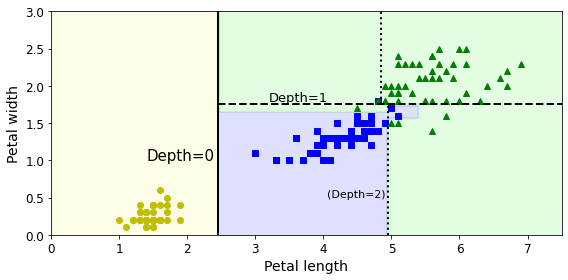

In [43]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[0, 7.5, 0, 3], iris=True, legend=False, plot_training=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)      #x1s와 x2s를 조합한 모든 좌표
    X_new = np.c_[x1.ravel(), x2.ravel()]
    
    y_pred = clf.predict(X_new).reshape(x1.shape)       #(100, 100)로 재배열 
                                                        #만들어진 각 좌표에 대해 예측되는 클래스
    
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)      #각 좌표마다 예측된 클래스별로 색을 칠한다
    
    if not iris:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    
    if plot_training:       #훈련세트 산점도로 표시
        plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris setosa")
        plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris versicolor")
        plt.plot(X[:, 0][y==2], X[:, 1][y==2], "g^", label="Iris virginica")
        plt.axis(axes)
    
    if iris:
        plt.xlabel("Petal length", fontsize=14)
        plt.ylabel("Petal width", fontsize=14)
    
    else:
        plt.xlabel(r"$x_1$", fontsize=18)
        plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    
    if legend:
        plt.legend(loc="lower right", fontsize=14)

plt.figure(figsize=(8, 4))

plot_decision_boundary(tree_clf, X, y)

plt.plot([2.45, 2.45], [0, 3], "k-", linewidth=2)           #depth=0에 해당하는 선
plt.plot([2.45, 7.5], [1.75, 1.75], "k--", linewidth=2)     #depth=1에 해당하는 파선
plt.plot([4.95, 4.95], [0, 1.75], "k:", linewidth=2)        #depth=2에 해당하는 점선 (보라색영역에서)
plt.plot([4.85, 4.85], [1.75, 3], "k:", linewidth=2)        #depth=2에 해당하는 점선 (초록색영역에서)

plt.text(1.40, 1.0, "Depth=0", fontsize=15)
plt.text(3.2, 1.80, "Depth=1", fontsize=13)
plt.text(4.05, 0.5, "(Depth=2)", fontsize=11)

save_fig("decision_tree_decision_boundaries_plot")
plt.show()

# 클래스와 클래스 확률을 예측하기

데이터 샘플이 리프 노드에 도착했을때 그 노드에서 클래스 비율이 가장 높은 클래스로 예측된다 

In [44]:
iris = load_iris()
X = iris.data[:, 2:] # 꽃잎 길이와 너비
y = iris.target

tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)

tree_clf.fit(X, y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=2, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [45]:
iris['feature_names']

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

In [46]:
tree_clf.predict_proba([[5, 1.5]])

array([[0.        , 0.90740741, 0.09259259]])

In [47]:
tree_clf.predict([[5, 1.5]])

array([1])

# 훈련 세트에 민감함

In [48]:
X[(X[:, 1]==X[:, 1][y==1].max()) & (y==1)]  
#X[:, 1]==X[:, 1][y==1].max()) & (y==1) 
#->클래스가 1인(버지컬러종)데이터의 1번째 특성(꽃잎의 너비)이 
#가장 큰 값에 True 나머지는 False

#위 조건을 만족한 데이터 샘플의 꽃잎의 길이, 꽃잎의 너비 출력

array([[4.8, 1.8]])

 y==2 도 추가하는 이유 : 우리가 할껀 버지컬러에 꽃잎너비가 가장 큰 걸 제외하려는 거고 클래스가 2인 버지니카종에는 꽃잎 너비가 1.8보다 큰것들이 있기 때문에 '또는'으로 조건을 걸어줘야한다.

In [49]:
not_widest_versicolor = (X[:, 1]!=1.8) | (y==2)   # 위에 조건을 만족한 데이터샘플 1개를 제외 
X_tweaked = X[not_widest_versicolor]
y_tweaked = y[not_widest_versicolor]

tree_clf_tweaked = DecisionTreeClassifier(max_depth=2, random_state=40)
tree_clf_tweaked.fit(X_tweaked, y_tweaked)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=2, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=40, splitter='best')

그림 저장: decision_tree_instability_plot


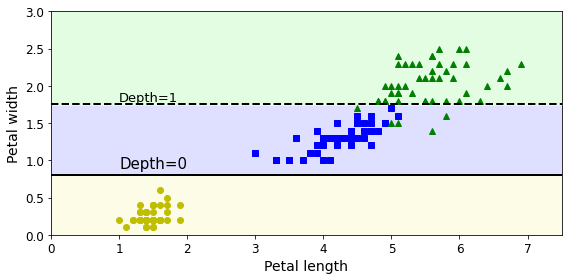

In [50]:
plt.figure(figsize=(8, 4))

plot_decision_boundary(tree_clf_tweaked, X_tweaked, y_tweaked, legend=False)

plt.plot([0, 7.5], [0.8, 0.8], "k-", linewidth=2)
plt.plot([0, 7.5], [1.75, 1.75], "k--", linewidth=2)
plt.text(1.0, 0.9, "Depth=0", fontsize=15)
plt.text(1.0, 1.80, "Depth=1", fontsize=13)

save_fig("decision_tree_instability_plot")
plt.show()

꽃잎 길이를 사용하지 않고 꽃잎 너비만 가지고 트리가 성장한다

결정트리는 제약이 없으면 모든 리프 노드가 순수 노드(불순도 0)가 될 때까지 성장 -> 훈련세트에 과대 적합

사전 가지치기(모델 규제)

자식 노드의 데이터 샘플의 갯수가 min_samples_leaf갯수 보다 작아지면 분할을 하지 않고 현재상태에서 멈춤

만약 실수값(예로 0.05)이면 자식 노드의 데이터 샘플의 갯수가 전체 샘플의 max_samples_leaf배 이상(전체의 5%이상)이 돼야 분할을 한다 

그림 저장: min_samples_leaf_plot


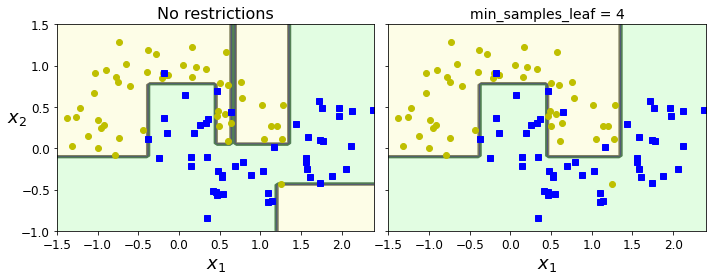

In [51]:
from sklearn.datasets import make_moons

Xm, ym = make_moons(n_samples=100, noise=0.25, random_state=53)

deep_tree_clf1 = DecisionTreeClassifier(random_state=42)        #제약이 없다
deep_tree_clf2 = DecisionTreeClassifier(min_samples_leaf=4, random_state=42)
deep_tree_clf1.fit(Xm, ym)
deep_tree_clf2.fit(Xm, ym)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])        #왼쪽 그림
plot_decision_boundary(deep_tree_clf1, Xm, ym, axes=[-1.5, 2.4, -1, 1.5], iris=False)
plt.title("No restrictions", fontsize=16)

plt.sca(axes[1])        #오른쪽 그림
plot_decision_boundary(deep_tree_clf2, Xm, ym, axes=[-1.5, 2.4, -1, 1.5], iris=False)
plt.title("min_samples_leaf = {}".format(deep_tree_clf2.min_samples_leaf), fontsize=14)
plt.ylabel("")

save_fig("min_samples_leaf_plot")
plt.show()

왼쪽은 제약이 없어서 훈련 세트에 과대적합되었다.

데이터 셋이 회전하면 결정 경계가 바뀐다.

어떤 값보다 크다 작도로 나누기 때문에 결정경계가 각 특성축에 수직인 형태만 가진다

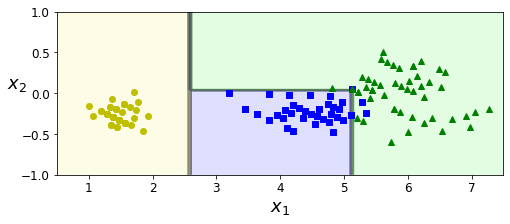

In [52]:
angle = np.pi / 180 * 20        #20도 회전
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
#[[cos      -sin
#  sin       cos ]]

Xr = X.dot(rotation_matrix)

tree_clf_r = DecisionTreeClassifier(random_state=42)
tree_clf_r.fit(Xr, y)

plt.figure(figsize=(8, 3))
plot_decision_boundary(tree_clf_r, Xr, y, axes=[0.5, 7.5, -1.0, 1], iris=False)

plt.show()

처음에 한 것과는 다른 경계가 만들어졌다

그림 저장: sensitivity_to_rotation_plot


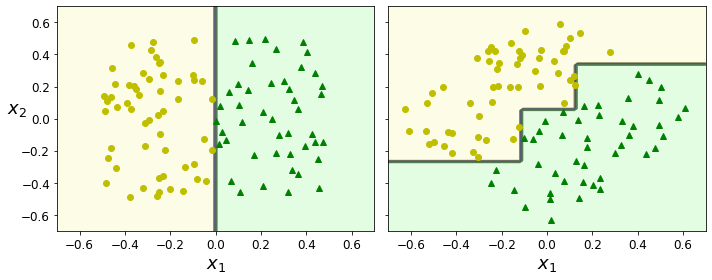

In [53]:
np.random.seed(6)
Xs = np.random.rand(100, 2) - 0.5       # -0.5~0.5 사이에 (100, 2) 
ys = (Xs[:, 0] > 0).astype(np.float32) * 2      #0보다 크면 1 아니면 0인데 2를 곱해서 2 아니면 0이 된다

angle = np.pi / 4       #45도 
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
Xsr = Xs.dot(rotation_matrix)   #위에서 만든 데이터셋 45도 회전 

tree_clf_s = DecisionTreeClassifier(random_state=42)
tree_clf_s.fit(Xs, ys)
tree_clf_sr = DecisionTreeClassifier(random_state=42)
tree_clf_sr.fit(Xsr, ys)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])    #왼쪽 그래프
plot_decision_boundary(tree_clf_s, Xs, ys, axes=[-0.7, 0.7, -0.7, 0.7], iris=False)

plt.sca(axes[1])       #오른쪽 그래프
plot_decision_boundary(tree_clf_sr, Xsr, ys, axes=[-0.7, 0.7, -0.7, 0.7], iris=False)
plt.ylabel("")

save_fig("sensitivity_to_rotation_plot")
plt.show()

# 회귀 트리

In [54]:
# 2차식으로 만든 데이터셋 + 잡음
np.random.seed(42)

m = 200     #데이터 갯수

X = np.random.rand(m, 1)        #0~1사이 균등분포 (200,1) / 특성 1개
y = 4 * (X - 0.5) ** 2      #2차 비선형
y = y + np.random.randn(m, 1) / 10

In [55]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg.fit(X, y)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

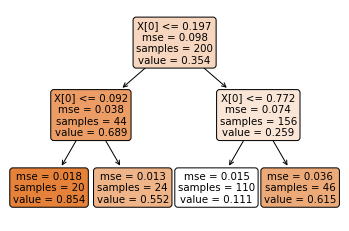

In [56]:
plot_tree(tree_reg, max_depth=2,
          filled=True, rounded=True)
plt.show()

그림 저장: tree_regression_plot


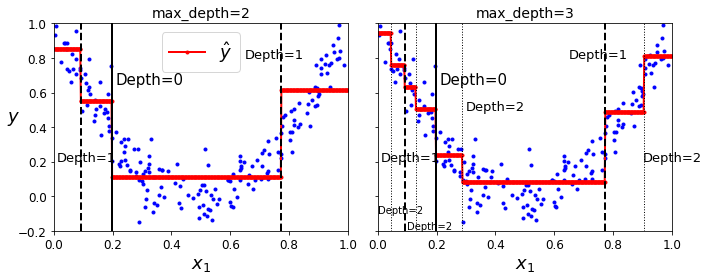

In [57]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(random_state=42, max_depth=2)
tree_reg2 = DecisionTreeRegressor(random_state=42, max_depth=3)
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)

def plot_regression_predictions(tree_reg, X, y, axes=[0, 1, -0.2, 1], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)      #(500, 1)
    y_pred = tree_reg.predict(x1)
    
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)
    plt.plot(X, y, "b.")
    plt.plot(x1, y_pred, "r.-", linewidth=2, label=r"$\hat{y}$")        #결정경계를 빨간선으로

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

plt.sca(axes[0])    #왼쪽 그래프
plot_regression_predictions(tree_reg1, X, y)

for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)

plt.text(0.21, 0.65, "Depth=0", fontsize=15)
plt.text(0.01, 0.2, "Depth=1", fontsize=13)
plt.text(0.65, 0.8, "Depth=1", fontsize=13)
plt.legend(loc="upper center", fontsize=18)
plt.title("max_depth=2", fontsize=14)

plt.sca(axes[1])        #오른쪽 그래프
plot_regression_predictions(tree_reg2, X, y, ylabel=None)

for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)

for split in (0.0458, 0.1298, 0.2873, 0.9040):
    plt.plot([split, split], [-0.2, 1], "k:", linewidth=1)

plt.text(0.21, 0.65, "Depth=0", fontsize=15)
plt.text(0.01, 0.2, "Depth=1", fontsize=13)
plt.text(0.65, 0.8, "Depth=1", fontsize=13)
plt.text(0.3, 0.5, "Depth=2", fontsize=13)
plt.text(0, -0.101, "Depth=2", fontsize=10)
plt.text(0.1, -0.19, "Depth=2", fontsize=10)
plt.text(0.9, 0.2, "Depth=2", fontsize=13)
plt.title("max_depth=3", fontsize=14)

save_fig("tree_regression_plot")
plt.show()

각 depth마다 결정경계를 표시한 선의 위치가 궁금 하면 밑에 트리 그림보면 알 수 있다.

빨간 선(결정경계)가 예측값인데 각 리프 노드의 평균값이다

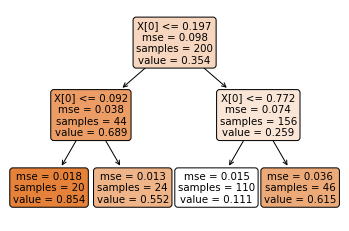

In [58]:
plot_tree(tree_reg1, max_depth=2,
          filled=True, rounded=True)
plt.show()

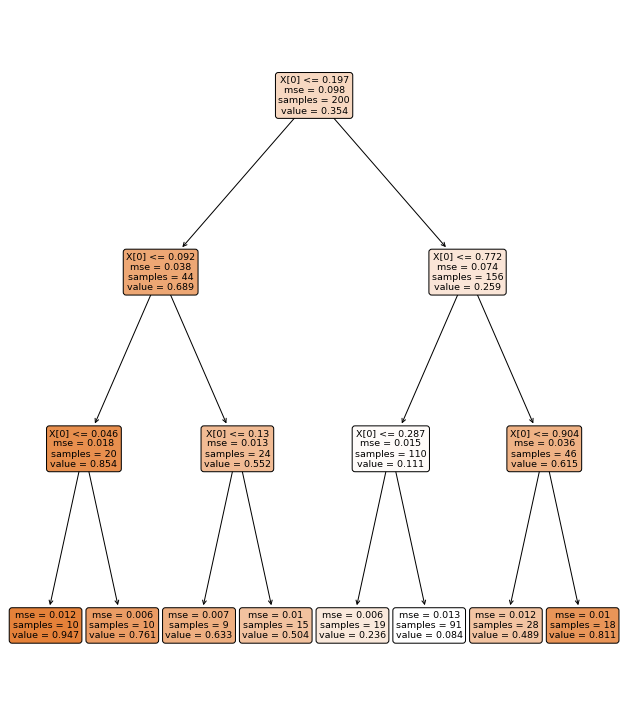

In [59]:
plt.figure(figsize=(11, 13))
plot_tree(tree_reg2, max_depth=3,
          filled=True, rounded=True)
plt.show()

In [60]:
export_graphviz(
        tree_reg1,
        out_file=os.path.join(IMAGES_PATH, "regression_tree.dot"),
        feature_names=["x1"],
        rounded=True,
        filled=True
    )

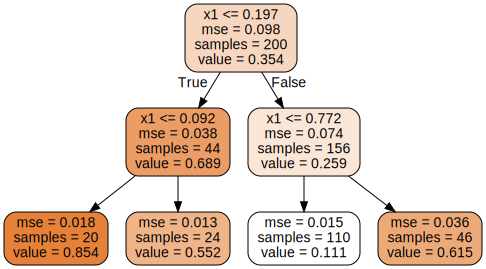

In [61]:
Source.from_file(os.path.join(IMAGES_PATH, "regression_tree.dot"))

회귀 모델은 criterion='mse'가 기본값이다(분류는 gini)

value : 각 노드의 평균값이고 예측값(값이 클수록 진하다)

그림 저장: tree_regression_regularization_plot


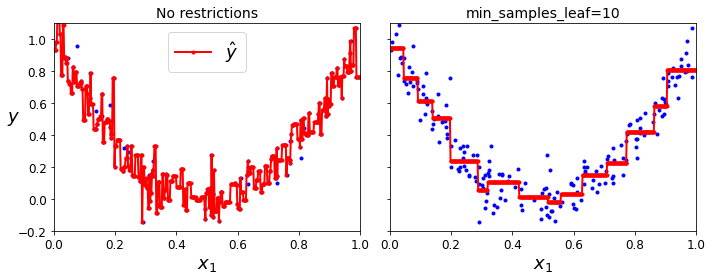

In [62]:
tree_reg1 = DecisionTreeRegressor(random_state=42)      #규제 x
tree_reg2 = DecisionTreeRegressor(random_state=42, min_samples_leaf=10) #규제 o
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)

x1 = np.linspace(0, 1, 500).reshape(-1, 1)
y_pred1 = tree_reg1.predict(x1)
y_pred2 = tree_reg2.predict(x1)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

plt.sca(axes[0])        #왼쪽 그래프
plt.plot(X, y, "b.")     #데이터 파란점
plt.plot(x1, y_pred1, "r.-", linewidth=2, label=r"$\hat{y}$")       #예측값 빨간선
plt.axis([0, 1, -0.2, 1.1])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", fontsize=18, rotation=0)
plt.legend(loc="upper center", fontsize=18)
plt.title("No restrictions", fontsize=14)

plt.sca(axes[1])        #오른쪽 그래프
plt.plot(X, y, "b.")    #데이터 파란점
plt.plot(x1, y_pred2, "r.-", linewidth=2, label=r"$\hat{y}$")       #예측값 빨간선
plt.axis([0, 1, -0.2, 1.1])
plt.xlabel("$x_1$", fontsize=18)
plt.title("min_samples_leaf={}".format(tree_reg2.min_samples_leaf), fontsize=14)

save_fig("tree_regression_regularization_plot")
plt.show()

왼쪽은 규제를 하지않아서 과대적합

# 연습문제 해답

## 1. to 6.

부록 A 참조.

## 7.

_문제: moons 데이터셋에 결정 트리를 훈련시키고 세밀하게 튜닝해보세요._

a. `make_moons(n_samples=1000, noise=0.4)`를 사용해 데이터셋을 생성합니다.

`random_state=42`를 지정하여 결과를 일정하게 만듭니다:

In [63]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=10000, noise=0.4, random_state=42)

b. 이를 `train_test_split()`을 사용해 훈련 세트와 테스트 세트로 나눕니다

In [64]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

c. `DecisionTreeClassifier`의 최적의 매개변수를 찾기 위해 교차 검증과 함께 그리드 탐색을 수행합니다(`GridSearchCV`를 사용하면 됩니다). 힌트: 여러 가지 `max_leaf_nodes` 값을 시도해보세요.

In [65]:
from sklearn.model_selection import GridSearchCV

params = {'max_leaf_nodes': list(range(2, 100)), 'min_samples_split': [2, 3, 4]}
grid_search_cv = GridSearchCV(DecisionTreeClassifier(random_state=42), params, verbose=1, cv=3)

grid_search_cv.fit(X_train, y_train)

Fitting 3 folds for each of 294 candidates, totalling 882 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 882 out of 882 | elapsed:    9.7s finished


GridSearchCV(cv=3, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=42,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,


In [66]:
grid_search_cv.best_estimator_

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=17,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

d. 찾은 매개변수를 사용해 전체 훈련 세트에 대해 모델을 훈련시키고 테스트 세트에서 성능을 측정합니다. 대략 85~87%의 정확도가 나올 것입니다.

기본적으로 `GridSearchCV`는 전체 훈련 세트로 찾은 최적의 모델을 다시 훈련시킵니다(`refit=False`로 지정해서 바꿀 수 있습니다). 그래서 별도로 작업할 필요가 없습니다. 모델의 정확도를 바로 평가할 수 있습니다:

In [67]:
from sklearn.metrics import accuracy_score

y_pred = grid_search_cv.predict(X_test)
accuracy_score(y_test, y_pred)

0.8695

## 8.

_문제: 랜덤 포레스트를 만들어보세요._

a. 이전 연습문제에 이어서, 훈련 세트의 서브셋을 1,000개 생성합니다. 각각은 무작위로 선택된 100개의 샘플을 담고 있습니다. 힌트: 사이킷런의 `ShuffleSplit`을 사용할 수 있습니다.

In [68]:
from sklearn.model_selection import ShuffleSplit

n_trees = 1000
n_instances = 100

mini_sets = []

rs = ShuffleSplit(n_splits=n_trees, test_size=len(X_train) - n_instances, random_state=42)
for mini_train_index, mini_test_index in rs.split(X_train):
    X_mini_train = X_train[mini_train_index]
    y_mini_train = y_train[mini_train_index]
    mini_sets.append((X_mini_train, y_mini_train))

b. 앞에서 찾은 최적의 매개변수를 사용해 각 서브셋에 결정 트리를 훈련시킵니다. 테스트 세트로 이 1,000개의 결정 트리를 평가합니다. 더 작은 데이터셋에서 훈련되었기 때문에 이 결정 트리는 앞서 만든 결정 트리보다 성능이 떨어져 약 80%의 정확도를 냅니다.

In [69]:
from sklearn.base import clone

forest = [clone(grid_search_cv.best_estimator_) for _ in range(n_trees)]

accuracy_scores = []

for tree, (X_mini_train, y_mini_train) in zip(forest, mini_sets):
    tree.fit(X_mini_train, y_mini_train)
    
    y_pred = tree.predict(X_test)
    accuracy_scores.append(accuracy_score(y_test, y_pred))

np.mean(accuracy_scores)

0.8054499999999999

c. 이제 마술을 부릴 차례입니다. 각 테스트 세트 샘플에 대해 1,000개의 결정 트리 예측을 만들고 다수로 나온 예측만 취합니다(사이파이의 `mode()` 함수를 사용할 수 있습니다). 그러면 테스트 세트에 대한 _다수결 예측_이 만들어집니다.

In [70]:
Y_pred = np.empty([n_trees, len(X_test)], dtype=np.uint8)

for tree_index, tree in enumerate(forest):
    Y_pred[tree_index] = tree.predict(X_test)

In [71]:
from scipy.stats import mode

y_pred_majority_votes, n_votes = mode(Y_pred, axis=0)

d. 테스트 세트에서 이 예측을 평가합니다. 앞서 만든 모델보다 조금 높은(약 0.5~1.5% 정도) 정확도를 얻게 될 것입니다. 축하합니다. 랜덤 포레스트 분류기를 훈련시켰습니다!

In [72]:
accuracy_score(y_test, y_pred_majority_votes.reshape([-1]))

0.872